In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ROOTDIR_DATA = "/content/drive/MyDrive/Teaching&Thesis/Theaching_dataset/"

# Load Corrupted Cifar10

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0.incompleteD2YNRP/cifar10_corrupted-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/shot_noise_5/1.0.0. Subsequent calls will reuse this data.


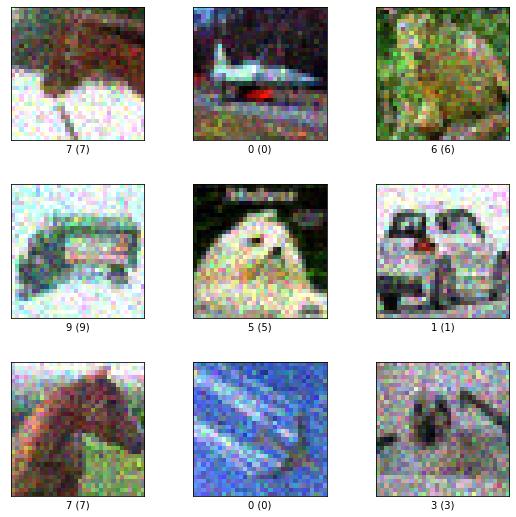

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteSTSGK7/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteSTSGK7/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [2]:
def process_data(image, label):
    return tf.keras.applications.resnet50.preprocess_input(image), tf.one_hot(label, 10, name='label', axis=-1)

shot_noise_5, shot_noise_5_info = tfds.load(
    'cifar10_corrupted/shot_noise_5',
    split='test',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

tfds.show_examples(shot_noise_5, shot_noise_5_info)

(cifar10_train, cifar10_test), cifar10_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

shot_noise_5 = shot_noise_5.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
shot_noise_5 = shot_noise_5.cache()
shot_noise_5 = shot_noise_5.batch(128)
shot_noise_5 = shot_noise_5.prefetch(tf.data.AUTOTUNE)

cifar10_train = cifar10_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_train = cifar10_train.cache()
cifar10_train = cifar10_train.shuffle(cifar10_info.splits['train'].num_examples)
cifar10_train = cifar10_train.batch(128)
cifar10_train = cifar10_train.prefetch(tf.data.AUTOTUNE)

cifar10_test = cifar10_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_test = cifar10_test.cache()
cifar10_test = cifar10_test.batch(128)
cifar10_test = cifar10_test.prefetch(tf.data.AUTOTUNE)

In [3]:
class ResNet50TTA(tf.keras.Model):
    def __init__(self, input_shape, num_classes=10):
        super(ResNet50TTA, self).__init__()
        self.base_model = tf.keras.Sequential([
                                               tf.keras.applications.ResNet50(
                                                   input_shape=input_shape,
                                                   pooling='avg',
                                                   include_top=False,
                                                   weights=None),
                                               tf.keras.layers.BatchNormalization()])
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.base_model(inputs, training=False)
        x = self.dropout(x)
        return self.classifier(x)

    def predict_many_times(self, ds, policy, repeat=1):
        pred_augmented = list()

        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(15, 15),
                tf.keras.layers.Resizing(28, 28)])]

        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal")])
        ]

        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.3, 0.3)])
        ]

        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(0.3)])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(repeat)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(repeat)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(repeat)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(repeat)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.predict(ds_augmented))

        return pred_augmented

In [4]:
net = ResNet50TTA(input_shape=(32, 32, 3))

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.8)
net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net.fit(cifar10_train, validation_data=cifar10_test, epochs=30)

Epoch 1/30
391/391 [==============================] - 100s 177ms/step - loss: 2.4118 - accuracy: 0.1283 - val_loss: 2.2446 - val_accuracy: 0.1523
Epoch 2/30
360/391 [==========================>...] - ETA: 4s - loss: 2.2144 - accuracy: 0.1604

In [ ]:
print("Accuracy on test set: {:.2f}".format(net.evaluate(cifar10_test)[1]))